# Image search


From a set of images the goal is to retrieve the most similar according to a unseen image.

The idea is to extract sift descriptors from all images, then compare those descriptors with the unseen image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import os
import glob

Process dataset stored at image_folder

In [3]:
image_folder = '/Users/danilonunes/Documents/Case Studies/Case Studies/code/book_covers/covers'

In [4]:
db = {}
extractor = cv2.SIFT()
images = glob.glob(os.path.join(image_folder, '*.png'))

for fname in images:
    img = cv2.imread(fname, 0)
    kps, desc = extractor.detectAndCompute(img, None)
    db[os.path.basename(fname)] = (kps, desc)

Our image description has a very high dimensionality

In [5]:
print db['cover001.png'][1].shape

(262, 128)


We need to create a compact representation of images

In order to perform it we apply two steps:

1. Clustering
1. Projecting descriptors into lower space
1. Index

## Clustering

In [6]:
from sklearn.cluster import MiniBatchKMeans
import scipy.cluster.vq as vq

In [7]:
n_clusters = 100
clf = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=1)

In [8]:
features = np.vstack((descriptor for _, descriptor in db.values()))

In [9]:
clf.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [10]:
print 'Centroids size:',clf.cluster_centers_.shape

Centroids size: (100, 128)


## Projection (histogram)

In [11]:
def project(descriptors, centroids):
    words, _ = vq.vq(descriptors, centroids)
    imhist, _ = np.histogram(words, bins=range(len(centroids) + 1), normed=False)
    return imhist

In [12]:
hist = {}
centroids = clf.cluster_centers_
n_words = len(centroids)

imwords = np.zeros((len(db), n_words))

for n, (image, (keypoints, descriptors)) in enumerate(db.iteritems()):
    imhist = project(descriptors, centroids)
    hist[image] = imhist
    imwords[n, :] = imhist

The idea is to create a sparse histogram

In [13]:
print 'image 001 now has {} dimensions'.format(hist['cover001.png'].shape)
print hist['cover001.png']

image 001 now has (100,) dimensions
[ 0  2  4  2  1  0 15  1 13  0  7  6  2  1  0  2  0  1  0  5  0  0  4  2  0
  0  0  1  0 21  0  2  3  0  0  2  0  0  0  6  3  2  2 14 23  2  0  1  2  1
  5  0  2  0  0  5  1  0  5  0  1  9  0  0  0  0  0  0  1  8  7  6  0  1  6
  0 15  1  2  0  0  3  1  0  1  0  0  1  0  0  0  3  6  3  4  0  4  3  0  5]


In [14]:
print 'Total of image words', imwords.shape

Total of image words (50, 100)


## Index (possible to weight by tfidf)

In [15]:
inv_index = {}
for word in xrange(len(centroids)):
    imgs_for_word = np.where(imwords[:, word] != 0.0)[0]
    inv_index[word] = imgs_for_word

In [16]:
print 'total of images containing feature 0:', len(inv_index[0])
print 'images', inv_index[0]

total of images containing feature 0: 39
images [ 0  1  2  3  4  6  7  8  9 10 12 14 15 16 17 19 20 21 22 23 24 25 26 29 31
 32 33 34 35 36 37 38 39 40 41 42 45 48 49]


# Query time

The following steps are necessary:

1. it is necessary to compute descriptors;
1. identify which features the query image has;
1. find out the images with same feature;
1. check if the retrieved images match.

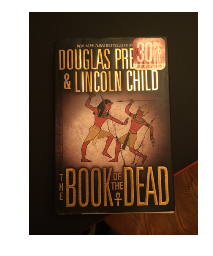

In [46]:
query_file = '/Users/danilonunes/Documents/Case Studies/Case Studies/code/book_covers/queries/query05.png'
query_image = cv2.imread(query_file)

plt.axis('off')
plt.imshow(query_image[:, :, ::-1])

### descriptors computation

In [47]:
img = cv2.cvtColor(query_image, cv2.COLOR_RGB2GRAY)
kps, desc = extractor.detectAndCompute(img, None)

### find relevant features in query image

In [48]:
imhistogram = project(desc, centroids)
print 'query histogram size:', imhistogram.shape

query histogram size: (100,)


In [49]:
relevant_features = np.where(imhistogram != 0)[0]
print len(relevant_features), relevant_features

98 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


### find out the images with same feature

In [50]:
from collections import Counter

imgs = []
for feature in relevant_features:
    for img in inv_index[feature]:
        imgs.append(img)

In [51]:
candidates = Counter(imgs)
print candidates.most_common(50)[:10]

[(22, 96), (12, 95), (21, 95), (34, 95), (48, 95), (49, 95), (10, 94), (6, 93), (7, 93), (14, 93)]


### We still have a lot of noise...

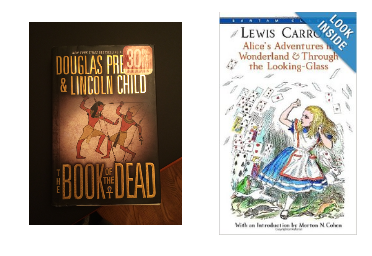

In [52]:
most_similar = candidates.most_common(1)[0]

plt.subplot(121)
plt.axis('off')
plt.imshow(query_image[:, :, ::-1])
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.imread(images[most_similar[0]])[:, :, ::-1])

## Re-ranking process

A new ranking strategy (costly) performed on top images

In [53]:
rank = []
for id_, _ in candidates.most_common(50):
    imname = os.path.basename(images[id_])
    candidate_histogram = hist[imname]
    rank.append((id_, np.linalg.norm(imhistogram - candidate_histogram)) )   

run matching algorithm only on top-10 images

In [54]:
rank_sorted = sorted(rank, key=lambda x: x[1])[:10]

In [55]:
matched = []

matcher = cv2.BFMatcher()
for rs, _ in rank_sorted:
    imname = os.path.basename(images[rs])
    (kp1, des1) = db[imname]

    rawMatches = matcher.knnMatch(desc, des1, 2)
    nmatches = -1
    
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.7:
            matches.append((m[0].queryIdx, m[0].trainIdx))

        if len(matches) > 50:
            ptsA = np.float32([kps[i].pt for (i, _) in matches])
            ptsB = np.float32([kp1[j].pt for (_, j) in matches])
            (_, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4.0)
            nmatches = float(status.sum()) / status.size
    
    
    matched.append((rs, nmatches))

In [56]:
matched_sorted = sorted(matched, key=lambda x: x[1])[::-1]

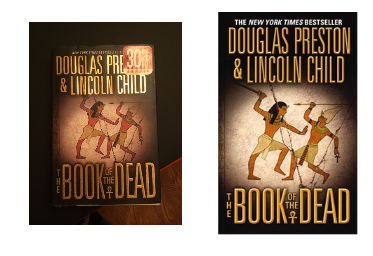

In [57]:
most_similar_from_match = matched_sorted[0][0]

plt.subplot(121)
plt.axis('off')
plt.imshow(query_image[:, :, ::-1])
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.imread(images[most_similar_from_match])[:, :, ::-1])